In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

from models import deconvolution

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = 'cpu'

torch.set_default_device(device)

/home/akseli/akseli/dippa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = int(2*N)
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

n_datasize = 1000
dataset = np.zeros((n_datasize, n))
x = np.linspace(domain[0],domain[1], n)

for ii in range(0, n_datasize):
    n_params = np.random.randint(4, 10)
    idxs = np.sort(np.random.randint(0+5, n-5, n_params))
    params = np.sort(np.random.uniform(0, 2, n_params))
    params[::2] = 0
    true = np.zeros(x.shape)

    for jj in range(0, len(idxs[1:])):
        true[idxs[jj-1]:idxs[jj]] = params[jj]
    
    dataset[ii, :] = true


In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

In [4]:
y_data = np.zeros((n_datasize, N))

for ii in range(0, n_datasize):
    f = dataset[ii, :]
    f = A@f
    ind = f > 0
    f *= ind

    # Create y_data with noise
    y_data[ii, :] = f + np.random.normal(0, sigma_noise, f.shape)

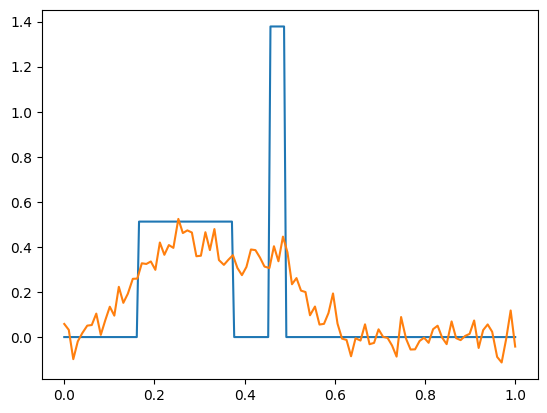

In [5]:
plt.plot(x, dataset[0, :])
plt.plot(t, y_data[0, :])

In [23]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
'''
Cauchy-jakaumia BNN:ään. 
'''
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0, 0.5).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Cauchy(0., 1.).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0, 0.5).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Cauchy(0, 0.5).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))#.squeeze()
        #mu = self.relu(self.fc2(mu))
        #mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.05))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [25]:
bnn_model = BNN(h1=N, h2=n)

# Set Pyro random seed
pyro.set_rng_seed(42)

nuts_kernel = pyro.infer.NUTS(bnn_model, jit_compile=True)

# Define MCMC sampler, get 50 posterior samples
bnn_mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=20)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(y_data).float()
y_train = torch.from_numpy(dataset).float()
data = [x_train, y_train]
# Run MCMC
bnn_mcmc.run(x_train, y_train)

Sample: 100%|██████████| 40/40 [00:04,  9.17it/s, step size=2.28e-02, acc. prob=0.000]


In [26]:

predictive = pyro.infer.Predictive(model=bnn_model, posterior_samples=bnn_mcmc.get_samples())
x_test = torch.linspace(domain[0], domain[1], 100)
preds = predictive(x_train[0,:])

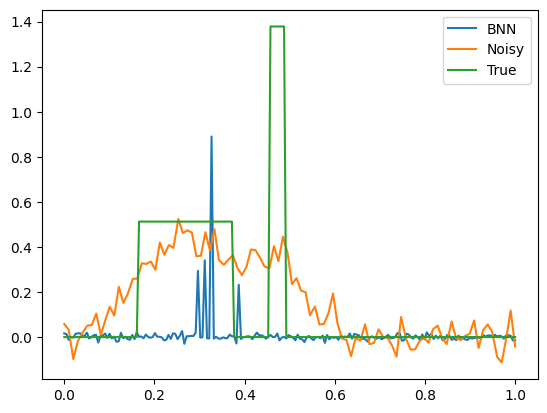

In [27]:
plt.plot(x, torch.mean(preds['obs'], axis=0))
plt.plot(t, x_train[0,:])
plt.plot(x, y_train[0, :])

plt.legend(['BNN', 'Noisy', 'True'])